# About

This notebook implements a pre-trained GPT language model to generate text.

In [1]:
!pip install transformers datasets git-lfs ipywidgets

     |████████████████████████████████| 2.9 MB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 287 kB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 14.4 MB/s eta 0:00:01
     |████████████████████████████████| 596 kB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 5.1 MB/s eta 0:00:011
     |████████████████████████████████| 243 kB 21.0 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 23.6 MB 516 kB/s  eta 0:00:01    |████████████▉                   | 9.5 MB 28.4 MB/s eta 0:00:01     |██████████████████████████▊     | 19.7 MB 21.9 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 6.7 MB/s  eta 0:00:01
     |████████████████████████████████| 1.3 MB 17.7 MB/s eta 0:00:01
     |████████████████████████████████| 125 kB 19.8 MB/s eta 0:00:01


     |████████████████████████████████| 160 kB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 271 kB 13.8 MB/s eta 0:00:01


In [12]:
!conda list

# packages in environment at C:\Users\Anton\Anaconda3\envs\storygen:
#
# Name                    Version                   Build  Channel
abseil-cpp                20210324.2           h0e60522_0    conda-forge
aiohttp                   3.7.4.post0      py38h294d835_0    conda-forge
argon2-cffi               21.1.0                   pypi_0    pypi
arrow-cpp                 5.0.0           py38h9929e98_8_cpu    conda-forge
async-timeout             3.0.1                   py_1000    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
aws-c-cal                 0.5.11               he19cf47_0    conda-forge
aws-c-common              0.6.2                h8ffe710_0    conda-forge
aws-c-event-stream        0.2.7               h70e1b0c_13    conda-forge
aws-c-io                  0.10.5               h2fe331c_0    conda-forge
aws-checksums             0.1.11               h1e232aa_7    conda-forge
aws-sdk-cpp               1.8.186              hb0612c5_3    co

In [10]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to C:\Users\Anton/.huggingface/token


# START


In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from datasets import load_dataset
from transformers import (
    pipeline,
    AdamW,
    AutoConfig,
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
)



In [3]:
# Load pretrained tokenizer and model
model_name = "pranavpsv/gpt2-genre-story-generator"
config=AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name,config=config)
model = AutoModelForCausalLM.from_pretrained(model_name)

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/166 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/203 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/487M [00:00<?, ?B/s]

In [4]:
# Sanity check of pre-trained model
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
stories = generator("<BOS> <superhero> Shrek", max_length=200, num_return_sequences=2)
print(*[story['generated_text'] + "\n\n\n------------------------\n" for story in stories])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<BOS> <superhero> Shrek and Nyssa are having a romantic weekend in an Abernathy, England-styled "Folk Hall" with Nyssa telling Shrek that despite her love for him, he's still not ready to leave. After a moment's thought, Shrek decides to propose, much to Nyssa's disappointment, but Shrek's uncle, Baron Wolfgang Blobber, objects to it. Later, Shrek and Nyssa go shopping for clothes. Meanwhile, Nyssa's best friend, Thelma Ritter, has just ended university, and she stops to buy her old dress. At a costume party, Shrek and Nyssa fall for one another; Shrek ends their date with Nyssa, but he cannot resist confessing his feelings to her. Shrek goes to Nyssa's old castle, where he finds her in bed with Baron Wolfgang, now the Baron's son. Shrek and Nyssa are


------------------------
 <BOS> <superhero> Shrek's First Season is introduced with the introduction of the recurring character "The Rumpus," who has appeared in all previous Shrek stories and is a member of the Rumpus family. After Shr

# Load dataset

First, we load the dataset and split into train and validation 

,genre,count
9,drama,19134
16,comedy,10467
18,romance film,6666
...,...,...
111,c-movie,1
286,comdedy,1
362,homoeroticism,1


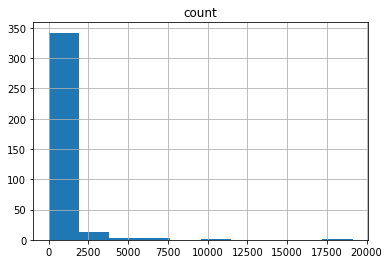

In [8]:
# Display genres and count
data = pd.read_csv('data/genres.csv',names=['genre', 'count'])
data=data.sort_values(by='count', ascending=False)
pd.set_option('display.max_rows', 7)

data.hist()
data.head(100000)

There are a lot of genres that orruces only a few times. We cannot learn from one sample, so these should be removed.

In [14]:
print(f'There are {len(data.loc[data["count"]<10])} genres with less than 10 occurences.')

There are 102 genres with less than 10 occurences.


In [5]:
# Load dataset from text file called "data.txt" and split into train/val
datasets = load_dataset("text", data_files="data.txt")['train']
datasets = datasets.train_test_split(train_size=0.975)
datasets['validation'] = datasets.pop('test')
datasets

Using custom data configuration default-94f8bf6e17e9d4f9
Reusing dataset text (C:\Users\Anton\.cache\huggingface\datasets\text\default-94f8bf6e17e9d4f9\0.0.0\e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5)


Loading cached split indices for dataset at C:\Users\Anton\.cache\huggingface\datasets\text\default-94f8bf6e17e9d4f9\0.0.0\e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5\cache-019ae2e90bbe9e93.arrow and C:\Users\Anton\.cache\huggingface\datasets\text\default-94f8bf6e17e9d4f9\0.0.0\e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5\cache-669fe46fd39678c0.arrow


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 40176
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1031
    })
})

In [6]:
# Example
print(datasets['train'][0]['text'] + '\n')
print(datasets['train'][1]['text'] + '\n')
print(datasets['train'][2]['text'])

<BOS> <thriller> <crime fiction> <melodrama> <world cinema> <musical> <drama> <suspense> <crime thriller> <bollywood> Baazigar <SEP> Ajay Sharma , is a man who seeks revenge. His father, Vishwanath Sharma , once owner of a great business empire, was defrauded by Madan Chopra , a trusted employee in Vishwanath's company. The Sharma family is ousted from their own company and loses everything they owned. Soon afterwards, Ajay's father and his young baby sister die due to illness, unable to buy medicine because of their destitute state. His mother  is now suffering from mental illness and memory loss. Driven over the edge, Ajay becomes obsessed with killing Chopra and destroying his family. Ajay begins dating Seema Chopra , the daughter of the owner of Chopra business empire. They meet secretly as her father would not approve of a poor son-in-law. Meanwhile, the younger daughter Priya Chopra  travels with her father Madan Chopra to Madras , for Madan's final kart race before he retires pe

As can be seen, the examples are of different lengths. Examples longer than 1024 tokens needs to be truncated as this is the maximum input to GPT2.

## Tokenization

We now need to tokenize the dataset. The pre-trained model that we are using have a few special tokens for a few genres. We need to add special tokens for all of our new genres as well as a special \<SEP\> token to the tokenizer.

In [7]:
new_special_tokens = ['<SEP>']
new_special_tokens.extend(['<' + str(genre) + '>' for genre in data['genre']])
print(new_special_tokens[:10])

['<SEP>', '<drama>', '<comedy>', '<romance film>', '<thriller>', '<action>', '<world cinema>', '<crime fiction>', '<horror>', '<black-and-white>']


In [8]:
# Add new special tokens to the tokenizer 
special_tokens = tokenizer.additional_special_tokens
special_tokens.extend(new_special_tokens) 
new_special_tokens_dict = {'additional_special_tokens': special_tokens}
num_added_toks = tokenizer.add_special_tokens(new_special_tokens_dict)

# We must resize token embeddings since new special tokens were added
model.resize_token_embeddings(len(tokenizer))

# Special tokens:
print(*tokenizer.all_special_tokens[:20])

<BOS> <EOS> <|endoftext|> <PAD> <superhero> <action> <drama> <thriller> <horror> <sci_fi> <SEP> <comedy> <romance film> <world cinema> <crime fiction> <black-and-white> <indie> <action/adventure> <adventure> <family film>


**Tokenize the dataset**

We tokenize the dataset. The tokenized examples contain the column names 'attention_mask' which is a mask for padding tokens and 'input_ids' which is the id of each token corrsponding to a word. We drop the text as that is not needed anymore. 

In [9]:
def tokenize_function(examples):
    """
    padding='max_length' to pad to a length specified by the max_length argument 
    or the maximum length accepted by the model.
    truncation=True to truncate each sequence to the maximum length accepted by the model
    """
    result = tokenizer(examples["text"], padding='max_length', truncation=True)
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_datasets = datasets.map(tokenize_function, batched=True, remove_columns=["text"])

Loading cached processed dataset at C:\Users\Anton\.cache\huggingface\datasets\text\default-94f8bf6e17e9d4f9\0.0.0\e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5\cache-8cca187c8a34f2b7.arrow


Note that we duplicate the inputs to add our labels. This is because the model of the 🤗 Transformers library apply the shifting to the right, so we don't need to do it manually.

In [10]:
#Make dataset format pytorch tensors
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 40176
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 1031
    })
})

In [11]:
# Finally, extract the datasets and select a subset if wanted
train_set = tokenized_datasets['train'].select(list(range(200)))
valid_set = tokenized_datasets['validation'].select(list(range(10)))

In [12]:
print(train_set, valid_set)

Dataset({
    features: ['attention_mask', 'input_ids', 'labels'],
    num_rows: 200
}) Dataset({
    features: ['attention_mask', 'input_ids', 'labels'],
    num_rows: 10
})


### Training
First, setup training args.
The last argument to setup everything so we can push the model to the Hub regularly during training..

Then pass training args to Trainer.

In [13]:
finetuned_model_name = "movie-plot-generator"
training_args = TrainingArguments(
    finetuned_model_name,
    evaluation_strategy = "no",
    num_train_epochs=1,
    learning_rate=1e-5,
    weight_decay=0.01,
    per_device_train_batch_size=1,
    push_to_hub=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=valid_set,
)

C:\Users\Anton\Desktop\Chalmers\ssy340\MoviePlotGeneration\movie-plot-generator is already a clone of https://huggingface.co/AntonClaesson/movie-plot-generator. Make sure you pull the latest changes with `repo.git_pull()`.


In [14]:
train_results=trainer.train()
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running training *****
  Num examples = 200
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 200


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 10
  Batch size = 8


RuntimeError: CUDA out of memory. Tried to allocate 1.54 GiB (GPU 0; 8.00 GiB total capacity; 4.31 GiB already allocated; 1.51 GiB free; 4.81 GiB reserved in total by PyTorch)

### Push to HUB

Push tokenizer and model to hub

In [15]:
tokenizer.save_pretrained("./finetuned_model_name/")
tokenizer.push_to_hub(finetuned_model_name)

tokenizer config file saved in ./finetuned_model_name/tokenizer_config.json
Special tokens file saved in ./finetuned_model_name/special_tokens_map.json
tokenizer config file saved in movie-plot-generator\tokenizer_config.json
Special tokens file saved in movie-plot-generator\special_tokens_map.json
To https://huggingface.co/AntonClaesson/movie-plot-generator
   03f5323..5dd6bdb  main -> main



'https://huggingface.co/AntonClaesson/movie-plot-generator/commit/5dd6bdb7551d31c6264df6003a9bae7a62a056b8'

In [16]:
trainer.push_to_hub()

Saving model checkpoint to movie-plot-generator
Configuration saved in movie-plot-generator\config.json
Model weights saved in movie-plot-generator\pytorch_model.bin


To https://huggingface.co/AntonClaesson/movie-plot-generator
   5dd6bdb..a5b4dab  main -> main



Dropping the following result as it does not have all the necessary field:
{'task': {'name': 'Causal Language Modeling', 'type': 'text-generation'}}
To https://huggingface.co/AntonClaesson/movie-plot-generator
   a5b4dab..72fbc7d  main -> main



'https://huggingface.co/AntonClaesson/movie-plot-generator/commit/a5b4dabc61120b768cf25330e1d14a20184ea655'

------
------
### Casual language modeling ## 
For causal language modeling (CLM) we are going to take all the texts in our dataset and concatenate them after they are tokenized. Then we will split them in examples of a certain sequence length. This way the model will receive chunks of contiguous text that may look like:
    
    part of text 1
    
or

    end of text 1 <BOS_TOKEN> beginning of text 2
    
 
depending on whether they span over several of the original texts in the dataset or not.
**Also the labels will be the same as the inputs, shifted to the left.**

Now for the harder part: we need to concatenate all our texts together then split the result in small chunks of a certain block_size. To do this, we will use the map method again, with the option batched=True. This option actually lets us change the number of examples in the datasets by returning a different number of examples than we got. This way, we can create our new samples from a batch of examples.
First, we grab the maximum length our model was pretrained with. This might be a big too big to fit in our GPU RAM, in that case decrease the size.

In [ ]:
#block_size = tokenizer.model_max_length
block_size = 128

Then we write the preprocessing function that will group our texts:


In [ ]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

First note that we duplicate the inputs for our labels. This is because the model of the 🤗 Transformers library apply the shifting to the right, so we don't need to do it manually.

Also note that by default, the map method will send a batch of 1,000 examples to be treated by the preprocessing function. So here, we will drop the remainder to make the concatenated tokenized texts a multiple of block_size every 1,000 examples. You can adjust this behavior by passing a higher batch size (which will also be processed slower). You can also speed-up the preprocessing by using multiprocessing:

In [ ]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)
print(lm_datasets)

And we can check our datasets have changed: now the samples contain chunks of block_size contiguous tokens, potentially spanning over several of our original texts.

In [ ]:
print(tokenizer.decode(lm_datasets["train"][0]["input_ids"]))
print()
print(tokenizer.decode(lm_datasets["train"][1]["input_ids"]))

Now that the data has been cleaned, we're ready to instantiate our Trainer.